# Twitter Sentiment Analysis | Machine Learning and Data Analytics
## Group 6b
Fabian Nolte - 333504

Niklas Alexander Muhs - 427432

Hans Anderson - 431907

# Preparations

## 1. Arguments

In [1]:
#Define fast mode to skip testing and only compute final model
fast_mode = True

## 2. Imports

In [2]:
#Importing relevant libraries

import numpy as np
import pandas as pd
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns
import mlxtend
from mlxtend.plotting import plot_confusion_matrix

import spacy
from random import shuffle

import nltk
from nltk.corpus import stopwords

from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import transformers
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.word.context_word_embs as nawcwe


import warnings
%matplotlib inline
pd.options.display.max_columns = None

from collections import Counter
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, f1_score, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold


from spellchecker import SpellChecker
import pickle

import os
import urllib.request
from transformers import AutoTokenizer, AutoModelForMaskedLM
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

# Data Preprocessing

In this section, functions for each aspect of data preprocessing are implemented. These are functions are called later in the testing section.

## 1. Cleaning

#### a. Lower Cases

In [3]:
def lowercase(tweet):
    tweet = tweet.lower()
    return tweet

In [4]:
def do_lowercase(data):
    data = data.apply(lambda x: lowercase(x))
    return data

#### b. Remove Special Characters (Hashtags, @user, Mails ...)

In [5]:
# remove special chars and extract hashtags

def remove_specialchars1(tweet):
    regex_1 = r'@\w+'
    tweet = re.sub(regex_1,'', tweet)
    
    regex_2 = r'[^0-9a-zA-Z|\s]'
    tweet = re.sub(regex_2,'', tweet)
        
    return tweet

def remove_specialchars2(tweet):
    regex_1 = r'((^|\s)(@|#|\W)(\S*))'
    tweet = re.sub(regex_1,'', tweet)
    
    regex_2 = r'[^0-9a-zA-Z|\s]'
    tweet = re.sub(regex_2,'', tweet)
    
    return tweet

In [6]:
def do_specialchars(data, n):
    if n == 1:
        data = data.apply(lambda x: remove_specialchars1(x))
    else:
        data = data.apply(lambda x: remove_specialchars2(x))
    return data

#### c. URLS

In [7]:
def remove_urls(tweet):
    
    regex = r'((https|http|www)\S+)'
    tweet = re.sub(regex,'', tweet)
    return tweet

In [8]:
def do_urls(data):
    data = data.apply(lambda x: remove_urls(x))
    return data

## 2. Spell Checking

In [9]:
spell = SpellChecker()

In [10]:
# Option 1: Keep words that cannot be corrected in original state
def correct_text_1(text):
    words = text.split()
    correct_words = []
    misspelled = spell.unknown(words)
    for w in words:
        if w in misspelled:
            correct_words.append(spell.correction(w))
        else:
            correct_words.append(w)
    return ' '.join(correct_words)

In [11]:
# Option 2: Remove words that cannot be corrected
def correct_text_2(text):
    words = text.split()
    correct_words = []
    misspelled = spell.unknown(words)
    for w in words:
        if w in misspelled:
            cw = spell.correction(w)
            if not cw == w:
                correct_words.append(cw)
        else:
            correct_words.append(w)
    return ' '.join(correct_words)

In [12]:
# apply spell checking to data set
def do_spellcheck(data, case):
    if case == 1:
        data = data.apply(lambda x: correct_text_1(x))
    elif case == 2:
        data = data.apply(lambda x: correct_text_2(x))
    return data

## 3. Stopwords

In [13]:
# remove all stopwords from a tweet
set(stopwords.words('english'))
def clean_stopwords(tweet):

    # splitting tweet into list with words as entries (tokenizing)
    tweet = tweet.split()
    # removing stopwords
    tweet = [word for word in tweet if not word in set(stopwords.words('english'))]
    # transforming tweet back to a string with whitespace
    tweet = ' '.join(tweet)

    return tweet


In [14]:
def do_stopwords(data):
    data = data.apply(lambda x: clean_stopwords(x))
    return data

##  4. Stemming and Lemmatization

#### a. Stemming

In [15]:
nltk.download('punkt')
stemmer = PorterStemmer()

def stem_words(tweet):
    return ' '.join([stemmer.stem(word) for word in word_tokenize(tweet)])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hansa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### b. Lemmatization (NLTK)

In [16]:
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

def lemmatize_words(tweet):
    return " ".join([lemmatizer.lemmatize(word) for word in tweet.split()])



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hansa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hansa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### c. Lemmatization (Spacy)

In [17]:
en_core = spacy.load('en_core_web_sm')

In [18]:
def do_stem_lem(data, case):
    if case == 1:
        data = data.apply(lambda x: stem_words(x))
    elif case == 2:
        data = data.apply(lambda x: lemmatize_words(x))
    elif case == 3:
        data = data.apply(lambda x: " ".join([y.lemma_ for y in en_core(x)]))
    
    return data      

# Testing

In this section, various combinations of data preprocessing and modelling approaches are tested. In order to do this, cases are defined and then run. The Stratified 5-Fold Cross-Validation is used to test each case as the dataset is very imbalanced and contains more normal tweets than hate speech tweets. The results are compared afterwards to choose the optimal preprocessing and model.

## 1. Define Cases to test

In [19]:
cases = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0.9, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 100],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 200],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 300],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 50],
        [1, 1, 1, 1, 1, 1, 0, 0, 10, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 100, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 200, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 300, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 400, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 50, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 500, 0],
        [1, 1, 1, 1, 1, 1, 0, 0.2, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0.4, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0.6, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0.8, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 1.0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0.1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0.2, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0.3, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0.3, 0, 200, 0],
        [1, 1, 1, 1, 1, 1, 0.4, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0.5, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0.6, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0.7, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0.8, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0.9, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 100],
        [1, 1, 1, 1, 1, 2, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 3, 0, 0, 0, 0],
        [1, 1, 1, 2, 1, 1, 0, 0, 0, 0],
        [1, 2, 1, 1, 1, 1, 0, 0, 0, 0]]

### Case Documentation

##### Data Preprocessing Options
case[0]: Lowercasing (int: [0,1]) --> 2 different options (with and without lowercasing) <br>
case[1]: Special Chars (int: [0,1,2]) --> 3 different options <br>
case[2]: URLs Removal (int: [0,1]) --> 2 different options (with and without)<br>
case[3]: Spellchecking (int: [0,1,2]) --> 3 different options <br>
case[4]: Stopwords (int: [0,1]) --> 2 different options (with and without) <br>
case[5]: Stemming/Lemmatization(int: [1,2,3]) --> 3 different options <br>

##### Handling Class Imbalance Options 
case[6]: Oversampling (float: [0,..,1]) --> seting the oversampling ratio <br>
case[7]: Data Augmentation (float: [0,..,1]) --> setting the oversampling ratio <br>

(Warning: case[6] and case[7] sould not simultaneously be unequal to 0)


##### Neural Network Options
case[8]: Embedding Dimension (int) --> Training the embedding layer on the basis of the training data <br>
case[9]: Pretrained Embedding Layer (int: [0,50,100,200,300]) --> 4 different pretrained GloVe Models (have to be downloaded, see instrucions)

(Warning: case[8] and case[9] sould not simultaneously be unequal to 0)

## 2. Load data augmentation

In [20]:
# Downloading Pretrained GLove Models (~840 MB)
if not fast_mode:
    urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')
    !unzip "glove.6B.zip" -d "./glove.6B/"

In [21]:
# Downloading Pretrained Bert Models (~420 MB)
if not fast_mode:
    AutoTokenizer.from_pretrained("bert-base-uncased")
    AutoModelForMaskedLM.from_pretrained("bert-base-uncased")

In [22]:
if not fast_mode:
    # example
    aug_bert = nawcwe.ContextualWordEmbsAug(model_path='bert-base-uncased',aug_p = 0.1, aug_min=0, aug_max=2,verbose=0)
    aug_bert.augment("the elections are fake! Go for trump!")

## 3. Load existing results

In [23]:
overall_results = dict()
overall_results = pickle.load( open( "final_results.p", "rb" ) )
print(overall_results)
print(cases)

{'[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]': {'f': {'BNB': 0.0, 'SVC': 0.7043417060044652, 'Logistical Regression': 0.4981657290581615, 'Neural Network': 0.5570253862491773}, 'MSE': {'BNB': 0.07014579267412906, 'SVC': 0.03444721688909197, 'Logistical Regression': 0.04883921948423329, 'Neural Network': 0.05002829381400613}}, '[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]': {'f': {'BNB': 0.0, 'SVC': 0.7043417060044652, 'Logistical Regression': 0.4981657290581615, 'Neural Network': 0.566071051498452}, 'MSE': {'BNB': 0.07014579267412906, 'SVC': 0.03444721688909197, 'Logistical Regression': 0.04883921948423329, 'Neural Network': 0.04921469371518089}}, '[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]': {'f': {'BNB': 0.0017797574857708488, 'SVC': 0.7093912280350448, 'Logistical Regression': 0.4923689066485279, 'Neural Network': 0.5283224335056209}, 'MSE': {'BNB': 0.07008321934562736, 'SVC': 0.033884061826853405, 'Logistical Regression': 0.048870459652854824, 'Neural Network': 0.049121007469253665}}, '[1, 1, 1, 0, 0, 0, 0, 0, 0, 0]': 

## 4. Define functions to process cases

In [24]:
def prepare_Data(prep_data, case):
    prep_data_temp = prep_data["tweet"]
    global last_run_data
    global last_case
    temp_case = case.copy()
    same = None
    process = list()
    for i in case:
        process.append(True)
    
    #Reuse previous preprocessing as much as possible
    if last_case != None:
        i = 0
        while i < len(last_case):
            if (last_case[i] == case[i]):
                case[i] = 0
                process[i] = False
                same = i
            else:
                break
            i += 1
    if same != None:
        prep_data_temp = last_run_data[str(same)]
        print("Reusing:", same)
        print(prep_data_temp.head())
    
    
    #lowercasing
    if case[0]:
        print("Lowercasing...")
        prep_data_temp = do_lowercase(prep_data_temp)
    if process[0]:
        last_run_data["0"] = prep_data_temp.copy()
    
    #Special Chars
    if case[1] != 0:
        print("Special Chars...")
        prep_data_temp = do_specialchars(prep_data_temp, case[1])
    if process[1]:
        last_run_data["1"] = prep_data_temp.copy()
    
    #URLS
    if case[2]:
        print("Removing URLs...")
        prep_data_temp = do_urls(prep_data_temp)
    if process[2]:
        last_run_data["2"] = prep_data_temp.copy()
    
    #SpellChecking
    if case[3] != 0:
        print("Spell Checking...")
        prep_data_temp = do_spellcheck(prep_data_temp, case[3])   
    if process[3]:
        last_run_data["3"] = prep_data_temp.copy()
    
    #Stopwords
    if case[4]:
        print("Removing Stopwords...")
        prep_data_temp = do_stopwords(prep_data_temp)
    if process[4]:
        last_run_data["4"] = prep_data_temp.copy()
    
    #Stemming and Lematization
    if case[5] != 0:
        print("Stemming or Lematization...")
        prep_data_temp = do_stem_lem(prep_data_temp, case[5])
    if process[5]:
        last_run_data["5"] = prep_data_temp.copy()
    
    #Dummy for oversampling
    if process[6]:
        last_run_data["6"] = prep_data_temp.copy()
        
    if process[7]:
        last_run_data["7"] = prep_data_temp.copy()
        
    if process[8]:
        last_run_data["8"] = prep_data_temp.copy()
        
    if process[9]:
        last_run_data["9"] = prep_data_temp.copy()


    
    last_case = temp_case.copy()
    prep_data["train"] = prep_data_temp
    return prep_data

#Defining evaluation metrices
def evaluate_f(y_valid, y_pred):
    return f1_score(y_valid, y_pred)

def evaluate_MSE(y_valid, y_pred):
    return mean_squared_error(y_valid, y_pred)


def run_Models(case_data, case):
    f_scores = {'BNB': 0, 'SVC': 0, 'Logistical Regression': 0, 'Neural Network': 0}
    MSE_scores = {'BNB': 0, 'SVC': 0, 'Logistical Regression': 0, 'Neural Network': 0}
        
    #Divide Training Set
    fold_K = 5
    
    temp_x = case_data.train.values
    temp_y = case_data.label.values

    kf = StratifiedKFold(n_splits=fold_K, shuffle=True, random_state=4)
    
    for b_train, b_test in kf.split(case_data["train"], case_data["label"]):
        x_train = temp_x[b_train]
        y_train = temp_y[b_train]
        x_test = temp_x[b_test]
        y_test = temp_y[b_test]
        
        print("Train: 1 =", len(y_train[y_train==1]),"| 0=",len(y_train[y_train==0]))
        print("Test: 1 =", len(y_test[y_test==1]),"| 0=",len(y_test[y_test==0]))
    

        #Do oversampling if in case
        if (case[6] > 0):
            print("------------------------------------ \nOversampling Ratio: ", case[6])

            sampling_ratio = case[6]
            # define oversampling strategy
            oversample = RandomOverSampler(sampling_strategy=sampling_ratio)

            # fit and apply the transform
            x_train, y_train = oversample.fit_resample(x_train.reshape(-1,1), y_train.reshape(-1,1))

            # summarize class distribution
            print("Distribution of oversampled Train Set:",Counter(y_train))

            x_train = x_train.flatten()
            y_train = y_train.flatten()
        
        
        
        
        
        ############# DATA AUGMENTATION ######################################        
        if (case[7] > 0):
            print("------------------------------------ \nData Augmentation Ratio: ", case[7])
            
    
            d = {'tweet': x_train, 'label': y_train}
            train_aug = pd.DataFrame(d, index=None)
            
            train_positive = train_aug[train_aug['label'] == 0]
            train_negative = train_aug[train_aug['label'] == 1]
            
            print("Actual ratio between positive and negative tweets:", len(train_negative)/len(train_positive))
    
    
            tweets_negative = np.ndarray.tolist(train_negative['tweet'].values) # transformed into list for data augmentation
            tweets_negative_aug =[tweet for tweet in tweets_negative if len(tweet.split()) >= 3] # only augment tweets with more than 3 words
            tweets_negative_naug = [tweet for tweet in tweets_negative if tweet not in set(tweets_negative_aug)] # tweets with less words --> easy oversampling
            
            data_aug = tweets_negative # data_aug contains also the original negative tweets
            
            # Sampling ratio for data augmentation
            ratio = case[7]
            n_positive = len(train_positive)
            n_negative = len(train_negative)
            n_aug =  round(((ratio*n_positive) / n_negative) - 1)
            #print('Augmentation loops:', n_aug)
            
            n = 0
            data_aug = tweets_negative # data_aug contains also the original negative tweets
            while (n < n_aug):
                print('loop:', n+1)
                temp_aug = aug_bert.augment(tweets_negative_aug) # created tweets

                data_aug = data_aug + temp_aug
                n += 1


            data_aug = data_aug + tweets_negative_naug*n_aug # simple oversampling of tweets with less than 3 words
            shuffle(data_aug) 
            
            # remove special chars and [UKN] = Unknown words
            def clean_aug(tweet):

                regex_1 = r'[^0-9a-zA-Z|\s]'
                tweet = re.sub(regex_1,'', tweet)

                tweet = tweet.strip()
                return tweet
            
            data_aug_clean = [clean_aug(tweet) for tweet in data_aug] # apply cleaning of augmented tweets
            data_aug_clean = [tweet for tweet in data_aug_clean if tweet] # remove empty strings ''
            
            d = {'tweet': data_aug, 'label': 1}
            train_negative_aug = pd.DataFrame(d, index=None)
            

            train_aug = pd.concat([train_positive, train_negative_aug], ignore_index=True)
            print(train_aug)
            train_aug.sample(frac=1) # shuffle
              
            x_train = train_aug['tweet'].values
            y_train = train_aug['label'].values
            
            print("Distribution of Augmentated Train Set:",Counter(y_train))
                      
        ##########################################################################   
        
        
        #Vectorize
        vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
        vectoriser.fit(x_train)
        VEC_x_test  = vectoriser.transform(x_test)
        VEC_x_train  = vectoriser.transform(x_train)

        #BNB
        BNBmodel = BernoulliNB()
        BNBmodel.fit(VEC_x_train, y_train)
        y_predict = BNBmodel.predict(VEC_x_test)
        f_scores["BNB"] += evaluate_f(y_test, y_predict)
        MSE_scores["BNB"] += evaluate_MSE(y_test, y_predict)

        #SVC
        SVCmodel = LinearSVC()
        SVCmodel.fit(VEC_x_train, y_train)
        y_predict = SVCmodel.predict(VEC_x_test)
        f_scores["SVC"] += evaluate_f(y_test, y_predict)
        MSE_scores["SVC"] += evaluate_MSE(y_test, y_predict)

        #Logistical Regression
        LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
        LRmodel.fit(VEC_x_train, y_train)
        y_predict = LRmodel.predict(VEC_x_test)
        f_scores["Logistical Regression"] += evaluate_f(y_test, y_predict)
        MSE_scores["Logistical Regression"] += evaluate_MSE(y_test, y_predict)


        if not fast_mode:

            #Neural Network
            #Restructure Data

            max_len = 500
            vocab_size = 2000 

            if case[8]:
                embedding_dim = case[8]
                print("------------------------------------ \nEmbedding Dimension: ", case[8])
            elif case[9]:
                embedding_dim = case[9]
                print("------------------------------------ \nUsing Pretrained Glove Model with Embedding Dimension: ", case[9])
            else:
                embedding_dim = 50
                print("Embedding Dimension is not definied. Setting it to default value 50")

            NN_x = x_train

            NN_tok = Tokenizer(num_words=2000)
            NN_tok.fit_on_texts(NN_x)
            NN_word_index = NN_tok.word_index


            NN_sequences = NN_tok.texts_to_sequences(NN_x)
            NN_x = sequence.pad_sequences(NN_sequences,maxlen=max_len)

            NN_sequences = NN_tok.texts_to_sequences(x_test)
            NN_x_test = sequence.pad_sequences(NN_sequences,maxlen=max_len)




            #Create Model
            def create_NN_model(): #Defined tensorflow_based_model function for training tenforflow based model
                model = Sequential()
                model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
                model.add(LSTM(64, return_sequences=False)),
                model.add(Dense(256, activation='relu')),
                model.add(Dropout(0.5)),
                model.add(Dense(1, activation='sigmoid')),


                return model #function returning the value when we call it


            NN_model = create_NN_model() # here we are calling the function to create a model


            ######## USING PRETRAINED GLOVE MODEL #########################
            if case[9]:
                print("Loading weights of GloVe",case[9])

                embeddings_index = {}
                glove_dir = './glove.6B'
                f = open(os.path.join(glove_dir, 'glove.6B.%sd.txt' %embedding_dim), encoding="utf8")

                for line in f:
                    values = line.split()
                    word = values[0]
                    coefs = np.asarray(values[1:], dtype='float32')
                    embeddings_index[word] = coefs
                f.close()
                print('Found %s word vectors.' % len(embeddings_index))


                # has to be equal to the loadel glove package
                embedding_matrix = np.zeros((vocab_size, embedding_dim))

                for word, i in NN_word_index.items():
                    if i < vocab_size:
                        embedding_vector = embeddings_index.get(word)
                        if embedding_vector is not None:
                            embedding_matrix[i] = embedding_vector

                NN_model.layers[0].set_weights([embedding_matrix])
                NN_model.layers[0].trainable = False
            else:
                NN_model.layers[0].trainable = True

            print("Embedding Layer is trainable: ",NN_model.layers[0].trainable,"\n------------------------------------")  
            ##################################################################



            NN_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

            #Fit model
            NN_model_fit = NN_model.fit(NN_x,y_train,batch_size=80,epochs=6, validation_split=0.1)
            NN_y_pred = NN_model.predict(NN_x_test)
            NN_y_pred = (NN_y_pred > 0.5)
            f_scores["Neural Network"] += evaluate_f(y_test, NN_y_pred)
            MSE_scores["Neural Network"] += evaluate_MSE(y_test, NN_y_pred)


    
    
    #Divide by K
    for key in f_scores.keys():
        f_scores[key] = f_scores[key]/fold_K
        
    for key in MSE_scores.keys():
        MSE_scores[key] = MSE_scores[key]/fold_K
    
    return f_scores, MSE_scores


## 5. Run test cases

In [25]:
if fast_mode:
    print("Fast-Mode active! Running only one exemplary case without saving results and leave out neural network model.")
    cases = [[1, 1, 1, 0, 1, 1, 0.3, 0, 0, 0]]

original_data = pd.read_csv('train.csv')

original_data.dropna(inplace=True)
print("Computing", len(cases), "cases!")

last_case = None
last_run_data = pd.DataFrame()
last_run_data["original"] = original_data["tweet"]

counter_test = 1
for c in cases.copy():
    print("################################################################### \nDoing Case",c,"n =",counter_test, "\n###################################################################")

    case_data = prepare_Data(original_data.copy(), c.copy())

    model_results_f, model_results_MSE = run_Models(case_data, c)
    print("Case",c,"results:")
    print({'f': model_results_f, 'Error Rate': model_results_MSE})
    print()
    if not fast_mode:
        overall_results[str(c)] = {'f': model_results_f, 'MSE': model_results_MSE}
    counter_test = counter_test + 1
    cases.remove(c)
        

Fast-Mode active! Running only one exemplary case without saving results and leave out neural network model.
Computing 1 cases!
################################################################### 
Doing Case [1, 1, 1, 0, 1, 1, 0.3, 0, 0, 0] n = 1 
###################################################################
Lowercasing...
Special Chars...
Removing URLs...
Removing Stopwords...
Stemming or Lematization...
Train: 1 = 1793 | 0= 23776
Test: 1 = 449 | 0= 5944
------------------------------------ 
Oversampling Ratio:  0.3
Distribution of oversampled Train Set: Counter({0: 23776, 1: 7132})
Train: 1 = 1793 | 0= 23776
Test: 1 = 449 | 0= 5944
------------------------------------ 
Oversampling Ratio:  0.3
Distribution of oversampled Train Set: Counter({0: 23776, 1: 7132})
Train: 1 = 1794 | 0= 23776
Test: 1 = 448 | 0= 5944
------------------------------------ 
Oversampling Ratio:  0.3
Distribution of oversampled Train Set: Counter({0: 23776, 1: 7132})
Train: 1 = 1794 | 0= 23776
Test: 1 = 44

## 6. Print and save results

In [26]:
print(overall_results)

{'[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]': {'f': {'BNB': 0.0, 'SVC': 0.7043417060044652, 'Logistical Regression': 0.4981657290581615, 'Neural Network': 0.5570253862491773}, 'MSE': {'BNB': 0.07014579267412906, 'SVC': 0.03444721688909197, 'Logistical Regression': 0.04883921948423329, 'Neural Network': 0.05002829381400613}}, '[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]': {'f': {'BNB': 0.0, 'SVC': 0.7043417060044652, 'Logistical Regression': 0.4981657290581615, 'Neural Network': 0.566071051498452}, 'MSE': {'BNB': 0.07014579267412906, 'SVC': 0.03444721688909197, 'Logistical Regression': 0.04883921948423329, 'Neural Network': 0.04921469371518089}}, '[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]': {'f': {'BNB': 0.0017797574857708488, 'SVC': 0.7093912280350448, 'Logistical Regression': 0.4923689066485279, 'Neural Network': 0.5283224335056209}, 'MSE': {'BNB': 0.07008321934562736, 'SVC': 0.033884061826853405, 'Logistical Regression': 0.048870459652854824, 'Neural Network': 0.049121007469253665}}, '[1, 1, 1, 0, 0, 0, 0, 0, 0, 0]': 

In [27]:
for key in overall_results.keys():
    print("Case", key)
    print(overall_results[key])
    print()

Case [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
{'f': {'BNB': 0.0, 'SVC': 0.7043417060044652, 'Logistical Regression': 0.4981657290581615, 'Neural Network': 0.5570253862491773}, 'MSE': {'BNB': 0.07014579267412906, 'SVC': 0.03444721688909197, 'Logistical Regression': 0.04883921948423329, 'Neural Network': 0.05002829381400613}}

Case [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
{'f': {'BNB': 0.0, 'SVC': 0.7043417060044652, 'Logistical Regression': 0.4981657290581615, 'Neural Network': 0.566071051498452}, 'MSE': {'BNB': 0.07014579267412906, 'SVC': 0.03444721688909197, 'Logistical Regression': 0.04883921948423329, 'Neural Network': 0.04921469371518089}}

Case [1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
{'f': {'BNB': 0.0017797574857708488, 'SVC': 0.7093912280350448, 'Logistical Regression': 0.4923689066485279, 'Neural Network': 0.5283224335056209}, 'MSE': {'BNB': 0.07008321934562736, 'SVC': 0.033884061826853405, 'Logistical Regression': 0.048870459652854824, 'Neural Network': 0.049121007469253665}}

Case [1, 1, 1, 0, 0, 0, 0, 0,

In [28]:
pickle.dump(overall_results, open( "final_results.p", "wb" ) )

# Final model

Based on the results from testing, the optimal combination of data preprocessing and modelling was then chosen using the F1-Score. This lead to the SVC model in combination with an oversampling rate of 0.3. Before applying the model, the data was preprocessed using lowercasing, the removal of special characters (only removing the hash-symbol of hashtags), URL removal, spellchecking (keeping words that cannot be spellchecked), the removal of stopwords and stemming. This is the case [1, 1, 1, 1, 1, 1, 0.3, 0, 0, 0].

In order to optimize runtime, the preprocessed data was saved in the files "data_train_prep.csv" that is loaded in this section. Additionally, the test data was also preprocessed and saved in the file "data_test_prep.csv".

In this section, the model is now applied on the preprocessed data using the Stratified Cross-Validation. As a result, confusion matrices are generated and the F1-Scores are calculated. Finally, the model is trained on the entire training set and is used to predict the test dataset.

In [29]:
data_train_prep = pd.read_csv("data_train_prep.csv")
data_train_prep.dropna(inplace=True)
data_test_prep = pd.read_csv("data_test_prep.csv")
data_test_prep.dropna(inplace=True)

## 1. Compute confusion matrices and F1-Scores using test data set only

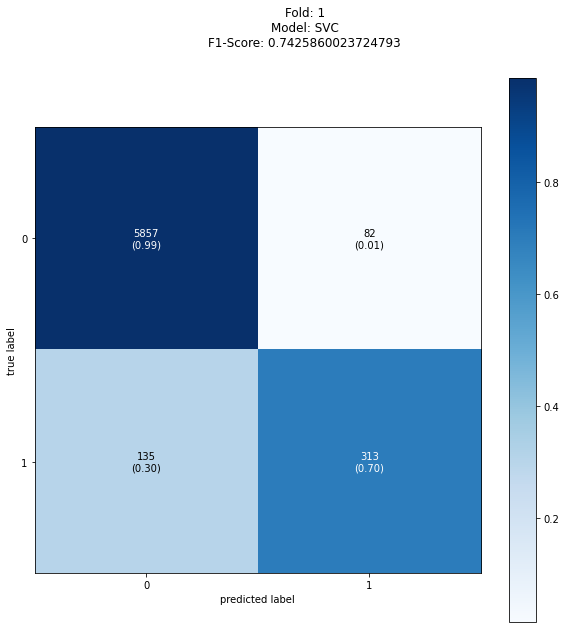

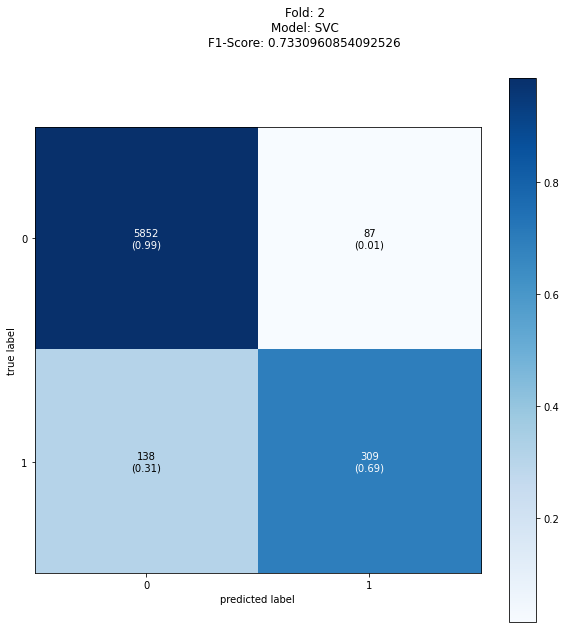

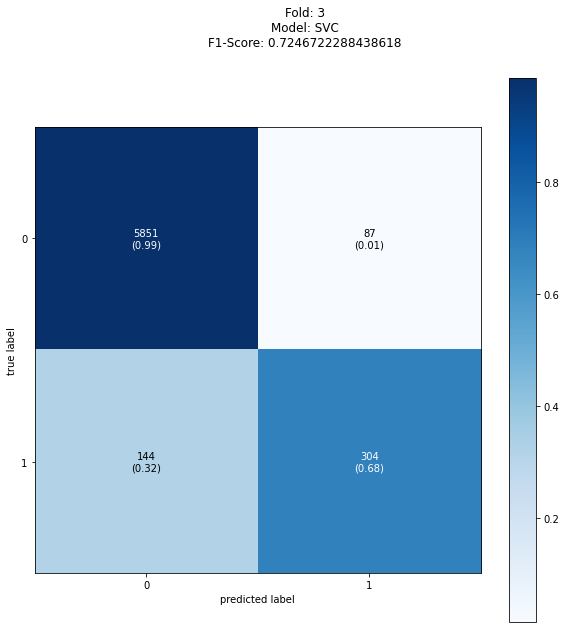

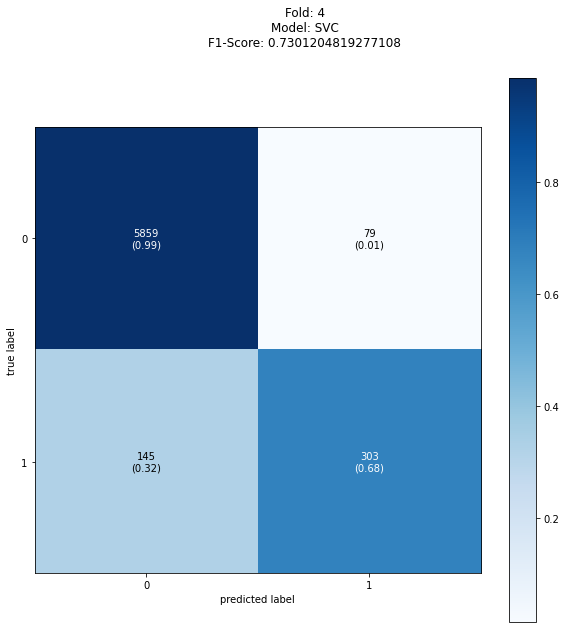

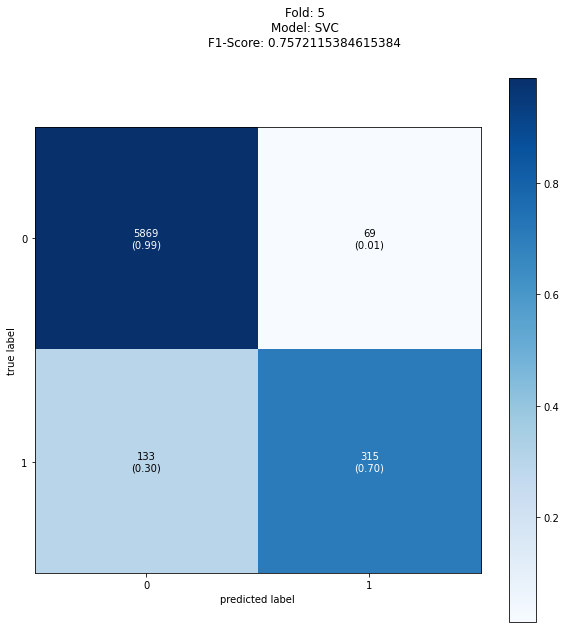

In [30]:
#Divide Training Set
fold_K = 5
temp_x = data_train_prep.train.values
temp_y = data_train_prep.label.values

kf = StratifiedKFold(n_splits=fold_K, shuffle=True, random_state=4)
fold = 1
for b_train, b_test in kf.split(data_train_prep["train"], data_train_prep["label"]):
    x_train = temp_x[b_train]
    y_train = temp_y[b_train]
    x_test = temp_x[b_test]
    y_test = temp_y[b_test]


    #Do oversampling
    sampling_ratio = 0.3
    # define oversampling strategy
    oversample = RandomOverSampler(sampling_strategy=sampling_ratio)

    # fit and apply the transform
    x_train, y_train = oversample.fit_resample(x_train.reshape(-1,1), y_train.reshape(-1,1))


    x_train = x_train.flatten()
    y_train = y_train.flatten()


    #Vectorize
    vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
    vectoriser.fit(x_train)
    VEC_x_test  = vectoriser.transform(x_test)
    VEC_x_train  = vectoriser.transform(x_train)

    #SVC
    SVCmodel = LinearSVC()
    SVCmodel.fit(VEC_x_train, y_train)
    y_predict = SVCmodel.predict(VEC_x_test)
    f_score = evaluate_f(y_test, y_predict)
    
    #Draw confusion matrix
    CR = confusion_matrix(y_test, y_predict)
    fig,ax = plot_confusion_matrix(conf_mat = CR, figsize=(10,10),
                                  show_absolute = True,
                                  show_normed = True,
                                  colorbar = True)
    fig.suptitle("Fold: "+str(fold)+"\nModel: SVC\n"+ "F1-Score: "+str(f_score), fontsize=12)
    plt.show()
    fold += 1


From the confusion matrices can be seen that for each fold the F1-Score is above 70%. In more detail, 99% of the normal tweets are identified correctly while there are only 1% false positives. On the other hand, around 70% of the tweets labelled as negative were identified as such, while there were around 30% false negatives.

## 2. Compute model for entire train data set and apply to test data set

In [31]:
x_train = data_train_prep.train.values
y_train = data_train_prep.label.values

x_test = data_test_prep.tweet_clean.values


#Do oversampling
sampling_ratio = 0.3
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy=sampling_ratio)

# fit and apply the transform
x_train, y_train = oversample.fit_resample(x_train.reshape(-1,1), y_train.reshape(-1,1))

x_train = x_train.flatten()
y_train = y_train.flatten()


#Vectorize
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(x_train)
VEC_x_test  = vectoriser.transform(x_test)
VEC_x_train  = vectoriser.transform(x_train)

#SVC
SVCmodel = LinearSVC()
SVCmodel.fit(VEC_x_train, y_train)


y_predict = SVCmodel.predict(VEC_x_test)

#Predict test data set
print("Predicted labels of test dataset:")
print(list(y_predict))
print()
result = data_test_prep.copy()
result["prediction"] = list(y_predict)
result.head(40)

Predicted labels of test dataset:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

,id,tweet,tweet_clean,prediction
0,31963,#studiolife #aislife #requires #passion #dedic...,studiolif dislik requir passion dedic willpow ...,0
1,31964,@user #white #supremacists want everyone to s...,white supremacist want everyon see new bird mo...,0
2,31965,safe ways to heal your #acne!! #altwaystohe...,safe way heal acn altwaystoh healthi heal,0
3,31966,is the hp and the cursed child book up for res...,curs child book reserv alreadi ye harrypott po...,0
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",ord bithday amaz hilari nephew eli amir uncl d...,0
5,31968,choose to be :) #momtips,choos mommi,0
6,31969,something inside me dies ð¦ð¿â¨ eyes nes...,someth insid die eye ness smokeyey tire lone s...,0
7,31970,#finished#tattoo#inked#ink#loveitâ¤ï¸ #â¤ï¸...,finishedtattooinkedinkloveit thanksaleee,0
8,31971,@user @user @user i will never understand why...,never understand dad left young deep inthefeel,0
9,31972,#delicious #food #lovelife #capetown mannaep...,delici food lowlif camptown mannaepicur restur,0


# Appendices

## 1. Impact of oversampling

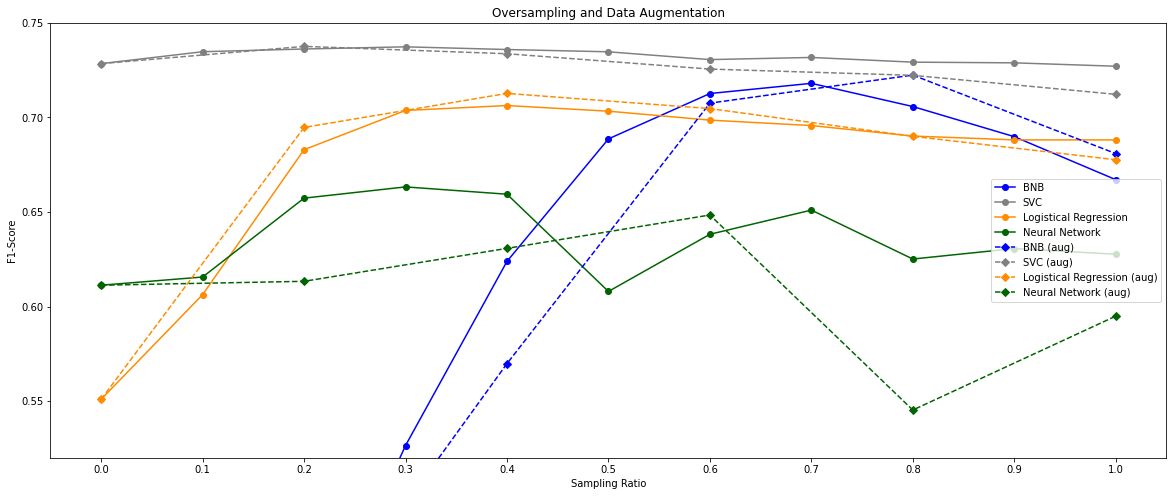

In [32]:
color_01 = 'blue'
color_02 = 'gray'
color_03 = 'darkorange'
color_04 = 'darkgreen'
results = pickle.load( open( "final_results.p", "rb" ) )
keys = [ast.literal_eval(list(results.keys())[i]) for i in range(0,len(results.keys()))]
keys_oversampling = sorted([key for key in keys if (key[0:6] == [1,1,1,1,1,1] and key[7]==key[8]==key[9]==0)])

x = [key[6] for key in keys_oversampling]

y_BNB = []
y_SVC = []
y_LR = []
y_NN = []

for key in keys_oversampling:
    key = str(key)
    y_BNB.append(results[key]['f']['BNB'])
    y_SVC.append(results[key]['f']['SVC'])
    y_LR.append(results[key]['f']['Logistical Regression'])
    y_NN.append(results[key]['f']['Neural Network'])
pd.DataFrame([y_BNB, y_SVC,y_LR, y_NN],index=['BNB','SVC','LR','NN'],columns=x).transpose()
plt.figure(figsize=(20, 8))
keys_augmented = sorted([key for key in keys if (key[0:7] == [1,1,1,1,1,1,0] and key[8]==key[9]==0)])

x_aug = [key[7] for key in keys_augmented]

y_BNB_aug = []
y_SVC_aug = []
y_LR_aug = []
y_NN_aug = []

for key in keys_augmented:
    key = str(key)
    y_BNB_aug.append(results[key]['f']['BNB'])
    y_SVC_aug.append(results[key]['f']['SVC'])
    y_LR_aug.append(results[key]['f']['Logistical Regression'])
    y_NN_aug.append(results[key]['f']['Neural Network'])

#Create the plots

plt.plot(x, y_BNB, color=color_01, marker='o', label = 'BNB')
plt.plot(x, y_SVC, color=color_02, marker='o', label = 'SVC')
plt.plot(x, y_LR, color=color_03, marker='o', label = 'Logistical Regression')
plt.plot(x, y_NN, color=color_04, marker='o', label = 'Neural Network')

plt.plot(x_aug, y_BNB_aug, color=color_01, linestyle='--', marker='D', label = 'BNB (aug)')
plt.plot(x_aug, y_SVC_aug, color=color_02,linestyle='--', marker='D', label = 'SVC (aug)')
plt.plot(x_aug, y_LR_aug, color=color_03, linestyle='--',marker='D', label = 'Logistical Regression (aug)')
plt.plot(x_aug, y_NN_aug, color=color_04, linestyle='--',marker='D', label = 'Neural Network (aug)')

#Create the title, axis description and legend
plt.title('Oversampling and Data Augmentation')
plt.ylabel('F1-Score')
plt.xlabel("Sampling Ratio")

plt.legend(loc=7, bbox_to_anchor=(1,0.5))
#plt.grid()
plt.xticks(x,rotation = 0)
plt.ylim(0.52,0.75)
plt.rcParams.update({'font.size': 12})

The previous plot shows the impact of oversampling in order to deal with the train data set's imbalance. It can be seen, that even though all models benefit from oversampling, the SVC model is most resistant against the dataset's imbalance. On the other hand, the BNB model benefits the most from oversampling.

## 2. Impact of pretrained embedding layer on the neural network model

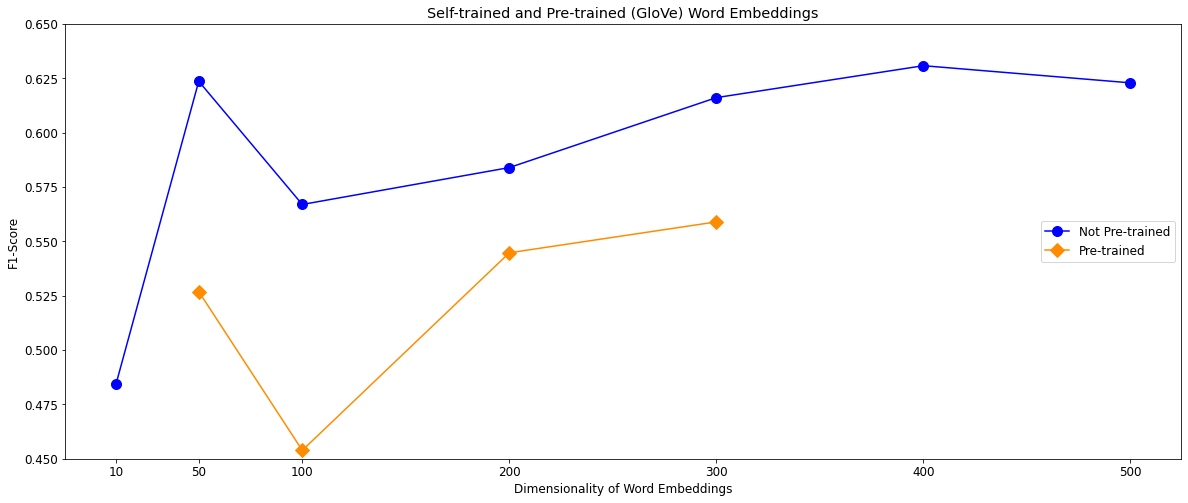

In [33]:
color_01 = 'blue'
color_02 = 'gray'
color_03 = 'darkorange'
color_04 = 'darkgreen'
results = pickle.load( open( "final_results.p", "rb" ) )
keys = [ast.literal_eval(list(results.keys())[i]) for i in range(0,len(results.keys()))]
keys_embdim = sorted([key for key in keys if key[0:7]==[1, 1, 1, 1, 1, 1, 0] and key[6]==key[7]==0])

keys_npretrained = [key for key in keys_embdim if key[8] > 0]
keys_pretrained = [key for key in keys_embdim if key[9] > 0]
plt.figure(figsize=(20, 8))
#Create the plots

x = [key[8] for key in keys_npretrained]

y_NN = []


for key in keys_npretrained:
    key = str(key)
    y_NN.append(results[key]['f']['Neural Network'])
    
y_NN_pretrained = []


for key in keys_pretrained:
    key = str(key)
    y_NN_pretrained.append(results[key]['f']['Neural Network'])
    
    
pd.DataFrame([y_NN, y_NN_pretrained],index=['Neural Network not pretrained','Neural Network pretrained'], columns=x).transpose()

plt.plot([key[8] for key in keys_npretrained], y_NN, color=color_01, marker='o', markersize=10, label = 'Not Pre-trained')
plt.plot([key[9] for key in keys_pretrained], y_NN_pretrained, color=color_03, marker='D', markersize=10, label = 'Pre-trained')

#Create the title, axis description and legend
plt.title('Self-trained and Pre-trained (GloVe) Word Embeddings')
plt.ylabel('F1-Score')
plt.xlabel("Dimensionality of Word Embeddings")

plt.legend(loc=7, bbox_to_anchor=(1,0.5))
#plt.grid()
plt.xticks(x,rotation = 0)
plt.ylim((0.45,0.65))
plt.rcParams.update({'font.size': 12})

The plot shows that in our case the pre-trained embedding layer didn't lead to improved results. The best results for the not pretrained model were computed with an embedding dimension of 400. An embedding dimension greater than 400 does not lead to significant improvements, but increases the computational complexity.

## 3. Visualization of the label distribution inside the dataset

0    29720
1     2242
Name: label, dtype: int64


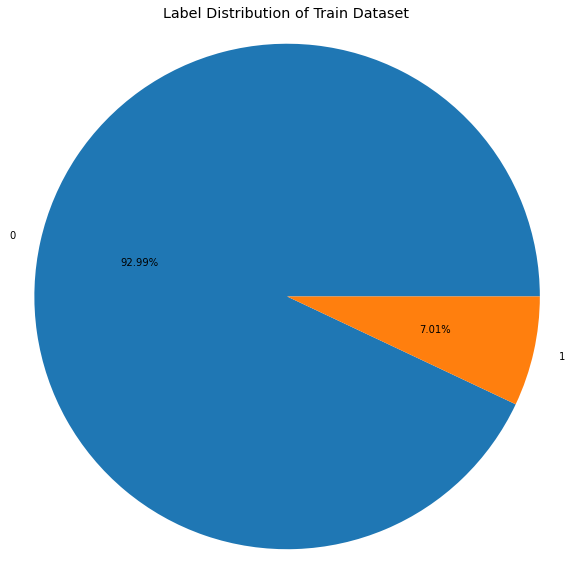

In [34]:
def create_pie(df, target_variable, title, figsize=(10, 10)):
    print(df[target_variable].value_counts())
    fig, ax = plt.subplots(figsize=figsize)
    ax.pie(df[target_variable].value_counts().values, labels=df[target_variable].value_counts().index, autopct='%1.2f%%', textprops={'fontsize': 10})
    ax.axis('equal')
    plt.title(title)
    plt.show()
    
train = pd.read_csv('train.csv')
create_pie(train, 'label', 'Label Distribution of Train Dataset')

The pie chart respresents the percentage amount of data inside the original dataset, split up into the different given labels.
Tweets with the label 1 are tweets containing hate speech and tweets with the label 0 are the opposite and contain no hate speech. 

## 4. Visualization of the most frequently occuring negative words

Text(0.5, 1.0, 'Most Frequently Occuring negative Words - Top 30')

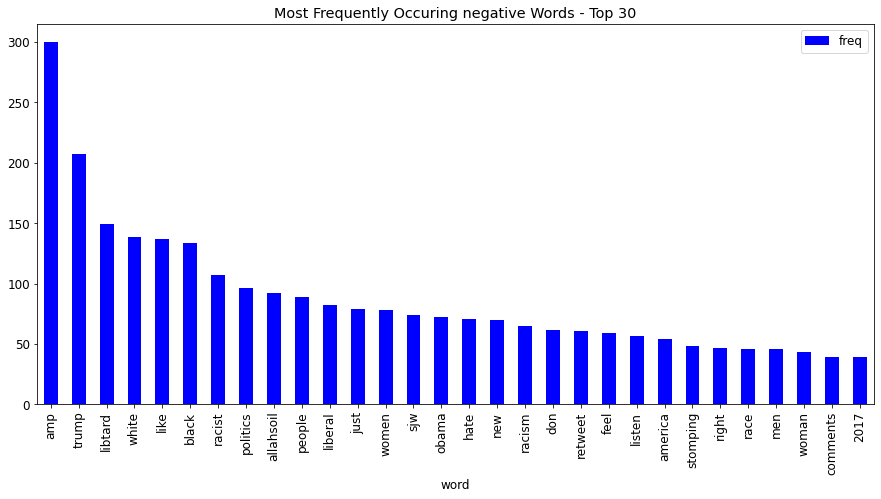

In [35]:
neg_df = train[train["label"] == 1]

cv_neg = CountVectorizer(stop_words = 'english')
words_neg = cv_neg.fit_transform(neg_df.tweet)

sum_words_neg = words_neg.sum(axis=0)

words_freq_neg = [(word, sum_words_neg[0, i]) for word, i in cv_neg.vocabulary_.items()]
words_freq_neg = sorted(words_freq_neg, key = lambda x: x[1], reverse = True)

frequency_neg = pd.DataFrame(words_freq_neg, columns=['word', 'freq'])
df = frequency_neg.iloc[1: , :]

df.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = color_01)
plt.title("Most Frequently Occuring negative Words - Top 30")

This bar plot contains the most frequently occuring negative words inside the originial dataset. The x-label conatins the individual word, while the y-label shows the amount of times the word is represented inside the data. 